[View in Colaboratory](https://colab.research.google.com/github/redcican/Master-Thesis/blob/master/07_2_Compare_L2_Regularization_Binary_Classification_Diabetes.ipynb)

# Compare the $L_2 $ Regularization on a  Binary Classification Task using Diabetes Datasets

## Data Visualization and Preprocessing

In [1]:
!wget https://raw.githubusercontent.com/redcican/Master-Thesis/master/Diabetes.csv

--2018-06-19 08:05:29--  https://raw.githubusercontent.com/redcican/Master-Thesis/master/Diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1268166 (1.2M) [text/plain]
Saving to: ‘Diabetes.csv.1’

Diabetes.csv.1      100%[===================>]   1.21M  --.-KB/s    in 0.04s   

2018-06-19 08:05:29 (33.9 MB/s) - ‘Diabetes.csv.1’ saved [1268166/1268166]



In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [0]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, regularizers, Activation, LeakyReLU, PReLU
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report,roc_curve,auc, confusion_matrix
from keras.utils import to_categorical

In [4]:
rawdf = pd.read_csv('Diabetes.csv')
rawdf.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician,Ln(Age)
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0,Dan Drayton,3.044522
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0,Anthony Frizzell,3.135494
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0,Gordon Fredrickson,3.135494
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1,Chad Corbitt,3.761200
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0,Zachary Fellows,3.091042


In [0]:
df = rawdf.copy()

#feature scale
ss = StandardScaler()
scale_features = ['PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI']
                  
df[scale_features] = ss.fit_transform(df[scale_features])

In [0]:
minmax = MinMaxScaler()
minmax_features = ['Pregnancies','DiabetesPedigree','Age','Ln(Age)']
df[minmax_features] = minmax.fit_transform(df[minmax_features])

In [7]:
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician,Ln(Age)
0,1354778,0.000000,1.974401,0.523884,0.356298,-0.863136,1.229683,0.510511,0.000000,0,Dan Drayton,0.000000
1,1147438,0.571429,-0.495823,1.299626,1.249448,-0.765438,-1.052302,0.036123,0.035714,0,Anthony Frizzell,0.070017
2,1640031,0.500000,0.223356,-1.445306,1.592967,-0.772953,1.024922,0.000438,0.035714,0,Gordon Fredrickson,0.070017
3,1883350,0.642857,-0.151868,0.404539,-0.262036,1.248633,-0.197512,0.541848,0.392857,1,Chad Corbitt,0.551595
4,1424119,0.071429,-0.714703,-0.729237,-0.124629,-0.772953,1.136926,0.212047,0.017857,0,Zachary Fellows,0.035804


In [27]:
X = df.drop(['PatientID','Physician','Diabetic'],axis=1).values
y = (df['Diabetic'].values).reshape(-1,1)
y = to_categorical(y,2)
X_train,X_test, Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(12000, 9) (12000, 2) (3000, 9) (3000, 2)


In [0]:
# For keras
def plot_confusion_matrix(model, X, Y):
  y_pred = model.predict_classes(X, verbose=0)
  plt.figure(figsize=(8,6))
  sns.heatmap(pd.DataFrame(confusion_matrix(Y, y_pred)), annot=True, fmt='d', cmap='YlGnBu',alpha=0.8,vmin=0)
  

## 1 .Deep Neural Networks for Classification using different loss Functions

In [0]:
batch_size = 256
epochs = 200

In [0]:
def model(regularizer):
  model = Sequential()
  model.add(Dense(32, input_shape=(X.shape[1],), activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(64, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(32, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(8, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(2, activation='softmax',kernel_regularizer=regularizer))
  model.compile('adam','binary_crossentropy',metrics=['accuracy'])
  
  return model

### 1.1   Neural Network without Regularization

In [20]:
regu_1 = None
model_1 = model(regu_1)
model_1.history = model_1.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 0.5640 - acc: 0.6818 - val_loss: 0.5060 - val_acc: 0.7407
Epoch 2/200
 - 0s - loss: 0.4693 - acc: 0.7772 - val_loss: 0.4235 - val_acc: 0.8163
Epoch 3/200
 - 0s - loss: 0.4059 - acc: 0.8142 - val_loss: 0.3796 - val_acc: 0.8300
Epoch 4/200
 - 0s - loss: 0.3789 - acc: 0.8277 - val_loss: 0.3648 - val_acc: 0.8387
Epoch 5/200
 - 0s - loss: 0.3638 - acc: 0.8384 - val_loss: 0.3617 - val_acc: 0.8373
Epoch 6/200
 - 0s - loss: 0.3533 - acc: 0.8398 - val_loss: 0.3510 - val_acc: 0.8490
Epoch 7/200
 - 0s - loss: 0.3425 - acc: 0.8467 - val_loss: 0.3494 - val_acc: 0.8477
Epoch 8/200
 - 0s - loss: 0.3329 - acc: 0.8511 - val_loss: 0.3438 - val_acc: 0.8543
Epoch 9/200
 - 0s - loss: 0.3235 - acc: 0.8563 - val_loss: 0.3383 - val_acc: 0.8563
Epoch 10/200
 - 0s - loss: 0.3126 - acc: 0.8651 - val_loss: 0.3250 - val_acc: 0.8610
Epoch 11/200
 - 0s - loss: 0.3006 - acc: 0.8695 - val_loss: 0.3125 - val_acc: 0.8697
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.1976 - acc: 0.9188 - val_loss: 0.2521 - val_acc: 0.8937
Epoch 35/200
 - 0s - loss: 0.1960 - acc: 0.9205 - val_loss: 0.2487 - val_acc: 0.9017
Epoch 36/200
 - 0s - loss: 0.1954 - acc: 0.9208 - val_loss: 0.2438 - val_acc: 0.8970
Epoch 37/200
 - 0s - loss: 0.1953 - acc: 0.9203 - val_loss: 0.2511 - val_acc: 0.8977
Epoch 38/200
 - 0s - loss: 0.1930 - acc: 0.9197 - val_loss: 0.2480 - val_acc: 0.8977
Epoch 39/200
 - 0s - loss: 0.1913 - acc: 0.9228 - val_loss: 0.2538 - val_acc: 0.8977
Epoch 40/200
 - 0s - loss: 0.1909 - acc: 0.9193 - val_loss: 0.2507 - val_acc: 0.8963
Epoch 41/200
 - 0s - loss: 0.1885 - acc: 0.9215 - val_loss: 0.2472 - val_acc: 0.8957
Epoch 42/200
 - 0s - loss: 0.1889 - acc: 0.9223 - val_loss: 0.2520 - val_acc: 0.8977
Epoch 43/200
 - 0s - loss: 0.1892 - acc: 0.9218 - val_loss: 0.2498 - val_acc: 0.8963
Epoch 44/200
 - 0s - loss: 0.1879 - acc: 0.9234 - val_loss: 0.2509 - val_acc: 0.8957
Epoch 45/200
 - 0s - loss: 0.1873 - acc: 0.9218 - val_loss: 0.2521 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.1661 - acc: 0.9308 - val_loss: 0.2542 - val_acc: 0.8997
Epoch 69/200
 - 0s - loss: 0.1714 - acc: 0.9274 - val_loss: 0.2500 - val_acc: 0.9013
Epoch 70/200
 - 0s - loss: 0.1677 - acc: 0.9293 - val_loss: 0.2534 - val_acc: 0.8980
Epoch 71/200
 - 0s - loss: 0.1662 - acc: 0.9312 - val_loss: 0.2563 - val_acc: 0.8993
Epoch 72/200
 - 0s - loss: 0.1662 - acc: 0.9293 - val_loss: 0.2590 - val_acc: 0.8960
Epoch 73/200
 - 0s - loss: 0.1653 - acc: 0.9316 - val_loss: 0.2557 - val_acc: 0.8983
Epoch 74/200
 - 0s - loss: 0.1685 - acc: 0.9298 - val_loss: 0.2571 - val_acc: 0.8943
Epoch 75/200
 - 0s - loss: 0.1658 - acc: 0.9315 - val_loss: 0.2623 - val_acc: 0.8987
Epoch 76/200
 - 0s - loss: 0.1652 - acc: 0.9304 - val_loss: 0.2533 - val_acc: 0.9007
Epoch 77/200
 - 0s - loss: 0.1618 - acc: 0.9319 - val_loss: 0.2620 - val_acc: 0.8990
Epoch 78/200
 - 0s - loss: 0.1608 - acc: 0.9338 - val_loss: 0.2547 - val_acc: 0.8970
Epoch 79/200
 - 0s - loss: 0.1624 - acc: 0.9316 - val_loss: 0.261

Epoch 102/200
 - 0s - loss: 0.1492 - acc: 0.9384 - val_loss: 0.2745 - val_acc: 0.8923
Epoch 103/200
 - 0s - loss: 0.1469 - acc: 0.9386 - val_loss: 0.2827 - val_acc: 0.8923
Epoch 104/200
 - 0s - loss: 0.1488 - acc: 0.9387 - val_loss: 0.2670 - val_acc: 0.8997
Epoch 105/200
 - 0s - loss: 0.1458 - acc: 0.9407 - val_loss: 0.2757 - val_acc: 0.8983
Epoch 106/200
 - 0s - loss: 0.1460 - acc: 0.9402 - val_loss: 0.2776 - val_acc: 0.8993
Epoch 107/200
 - 0s - loss: 0.1450 - acc: 0.9402 - val_loss: 0.2882 - val_acc: 0.8983
Epoch 108/200
 - 0s - loss: 0.1459 - acc: 0.9405 - val_loss: 0.2708 - val_acc: 0.8977
Epoch 109/200
 - 0s - loss: 0.1454 - acc: 0.9387 - val_loss: 0.2746 - val_acc: 0.8947
Epoch 110/200
 - 0s - loss: 0.1436 - acc: 0.9406 - val_loss: 0.2731 - val_acc: 0.8963
Epoch 111/200
 - 0s - loss: 0.1440 - acc: 0.9407 - val_loss: 0.2760 - val_acc: 0.8947
Epoch 112/200
 - 0s - loss: 0.1421 - acc: 0.9410 - val_loss: 0.2807 - val_acc: 0.8973
Epoch 113/200
 - 0s - loss: 0.1430 - acc: 0.9413 - val

Epoch 136/200
 - 0s - loss: 0.1302 - acc: 0.9493 - val_loss: 0.2962 - val_acc: 0.8957
Epoch 137/200
 - 0s - loss: 0.1315 - acc: 0.9454 - val_loss: 0.2878 - val_acc: 0.8923
Epoch 138/200
 - 0s - loss: 0.1371 - acc: 0.9442 - val_loss: 0.2990 - val_acc: 0.8997
Epoch 139/200
 - 0s - loss: 0.1318 - acc: 0.9447 - val_loss: 0.2904 - val_acc: 0.8973
Epoch 140/200
 - 0s - loss: 0.1332 - acc: 0.9448 - val_loss: 0.2968 - val_acc: 0.8957
Epoch 141/200
 - 0s - loss: 0.1313 - acc: 0.9459 - val_loss: 0.2940 - val_acc: 0.8960
Epoch 142/200
 - 0s - loss: 0.1319 - acc: 0.9458 - val_loss: 0.2893 - val_acc: 0.8953
Epoch 143/200
 - 0s - loss: 0.1290 - acc: 0.9486 - val_loss: 0.3033 - val_acc: 0.8943
Epoch 144/200
 - 0s - loss: 0.1278 - acc: 0.9479 - val_loss: 0.3060 - val_acc: 0.8930
Epoch 145/200
 - 0s - loss: 0.1270 - acc: 0.9483 - val_loss: 0.2999 - val_acc: 0.8963
Epoch 146/200
 - 0s - loss: 0.1266 - acc: 0.9482 - val_loss: 0.3040 - val_acc: 0.8947
Epoch 147/200
 - 0s - loss: 0.1259 - acc: 0.9486 - val

Epoch 170/200
 - 0s - loss: 0.1160 - acc: 0.9523 - val_loss: 0.3138 - val_acc: 0.8927
Epoch 171/200
 - 0s - loss: 0.1197 - acc: 0.9501 - val_loss: 0.3215 - val_acc: 0.8887
Epoch 172/200
 - 0s - loss: 0.1226 - acc: 0.9504 - val_loss: 0.3192 - val_acc: 0.8897
Epoch 173/200
 - 0s - loss: 0.1143 - acc: 0.9523 - val_loss: 0.3189 - val_acc: 0.8893
Epoch 174/200
 - 0s - loss: 0.1162 - acc: 0.9532 - val_loss: 0.3132 - val_acc: 0.8950
Epoch 175/200
 - 0s - loss: 0.1155 - acc: 0.9539 - val_loss: 0.3170 - val_acc: 0.8940
Epoch 176/200
 - 0s - loss: 0.1140 - acc: 0.9558 - val_loss: 0.3142 - val_acc: 0.8913
Epoch 177/200
 - 0s - loss: 0.1181 - acc: 0.9491 - val_loss: 0.3330 - val_acc: 0.8873
Epoch 178/200
 - 0s - loss: 0.1148 - acc: 0.9526 - val_loss: 0.3312 - val_acc: 0.8900
Epoch 179/200
 - 0s - loss: 0.1149 - acc: 0.9523 - val_loss: 0.3194 - val_acc: 0.8910
Epoch 180/200
 - 0s - loss: 0.1144 - acc: 0.9531 - val_loss: 0.3276 - val_acc: 0.8883
Epoch 181/200
 - 0s - loss: 0.1128 - acc: 0.9538 - val

             precision    recall  f1-score   support

          0       0.93      0.90      0.91      2002
          1       0.81      0.86      0.83       998

avg / total       0.89      0.89      0.89      3000



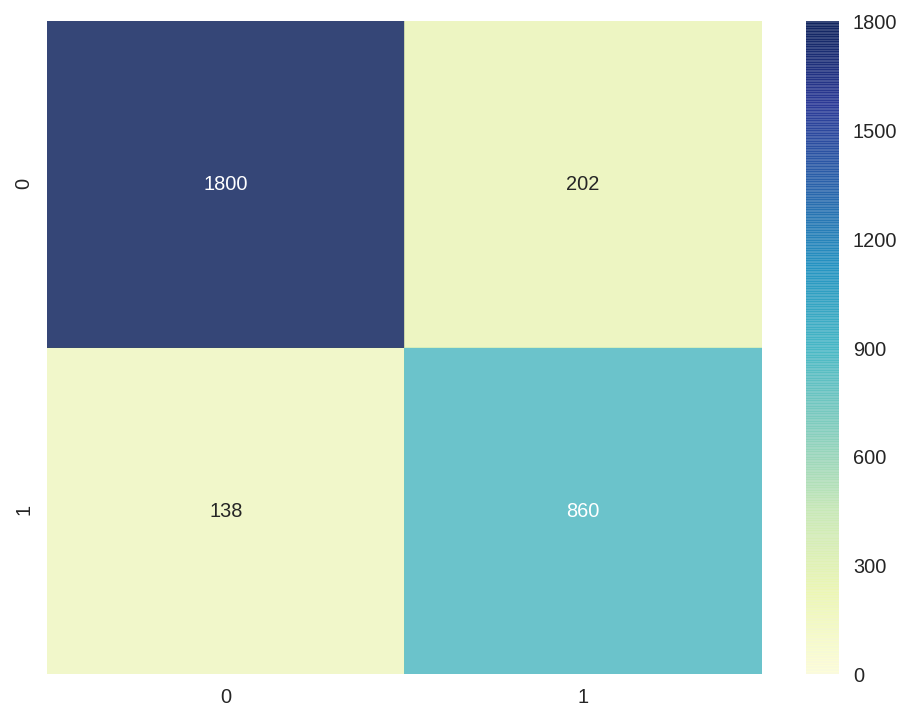

In [22]:
y_pred_1 = model_1.predict_classes(X_test,verbose=0)
y_test_class_1 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_1,y_pred_1))
plot_confusion_matrix(model_1,X_test,y_test_class_1)

In [23]:
train_loss_1, train_accuracy_1 = model_1.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_1 * 100, train_loss_1))
test_loss_1, test_accuracy_1 = model_1.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_1 * 100, test_loss_1))

Training Accuracy = 96.08 %     loss = 0.098440
Testing Accuracy = 88.67 %    loss = 0.342406


### 1.2 Neural Network with L2 Regularization $\lambda=0.1$

In [30]:
regu_2 = regularizers.l2(l=0.1)
model_2 = model(regu_2)
model_2.history = model_2.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 9.7371 - acc: 0.6263 - val_loss: 7.4492 - val_acc: 0.6673
Epoch 2/200
 - 0s - loss: 5.9143 - acc: 0.6665 - val_loss: 4.5679 - val_acc: 0.6673
Epoch 3/200
 - 0s - loss: 3.6735 - acc: 0.6665 - val_loss: 2.8911 - val_acc: 0.6673
Epoch 4/200
 - 0s - loss: 2.3758 - acc: 0.6665 - val_loss: 1.9264 - val_acc: 0.6673
Epoch 5/200
 - 0s - loss: 1.6333 - acc: 0.6665 - val_loss: 1.3782 - val_acc: 0.6673
Epoch 6/200
 - 0s - loss: 1.2134 - acc: 0.6665 - val_loss: 1.0699 - val_acc: 0.6673
Epoch 7/200
 - 0s - loss: 0.9777 - acc: 0.6665 - val_loss: 0.8966 - val_acc: 0.6673
Epoch 8/200
 - 0s - loss: 0.8446 - acc: 0.6665 - val_loss: 0.7981 - val_acc: 0.6673
Epoch 9/200
 - 0s - loss: 0.7682 - acc: 0.6665 - val_loss: 0.7408 - val_acc: 0.6673
Epoch 10/200
 - 0s - loss: 0.7231 - acc: 0.6665 - val_loss: 0.7063 - val_acc: 0.6673
Epoch 11/200
 - 0s - loss: 0.6956 - acc: 0.6665 - val_loss: 0.6849 - val_acc: 0.6673
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 35/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 36/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 37/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 38/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 39/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 40/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 41/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 42/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 43/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 44/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 45/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 69/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 70/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 71/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 72/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 73/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 74/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 75/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 76/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 77/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 78/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 79/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.636

Epoch 102/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 103/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 104/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 105/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 106/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 107/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 108/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 109/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 110/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 111/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 112/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 113/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val

Epoch 136/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 137/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 138/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 139/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 140/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 141/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 142/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 143/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 144/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 145/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 146/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 147/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val

Epoch 170/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 171/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 172/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 173/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 174/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 175/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 176/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 177/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 178/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 179/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 180/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 181/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.67      1.00      0.80      2002
          1       0.00      0.00      0.00       998

avg / total       0.45      0.67      0.53      3000



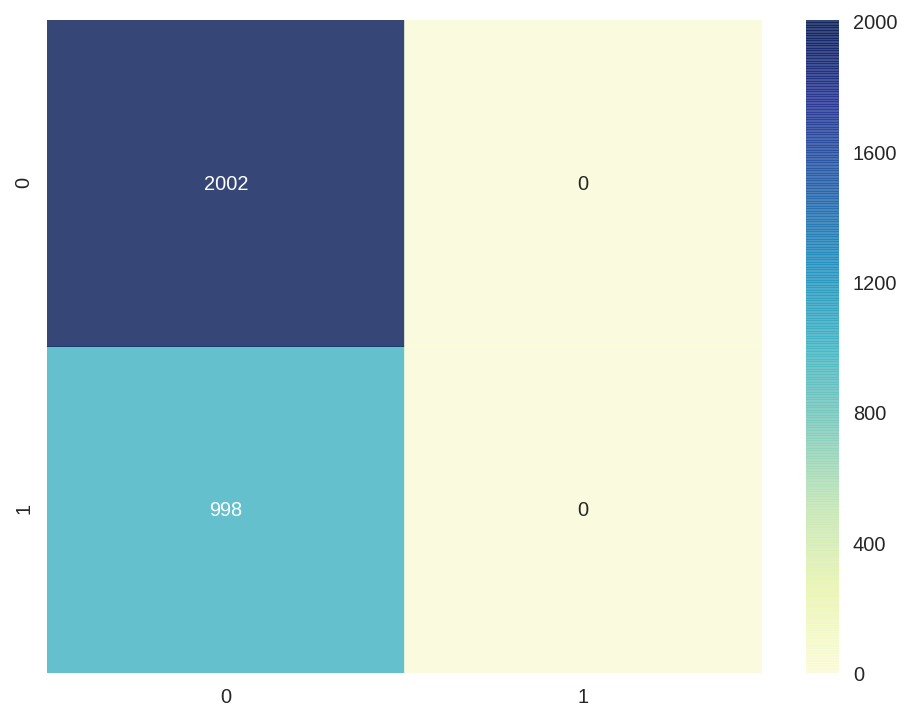

In [31]:
y_pred_2 = model_2.predict_classes(X_test,verbose=0)
y_test_class_2 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_2,y_pred_2))
plot_confusion_matrix(model_2,X_test,y_test_class_2)

In [32]:
train_loss_2, train_accuracy_2 = model_2.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_2 * 100, train_loss_2))
test_loss_2, test_accuracy_2 = model_2.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_2 * 100, test_loss_2))

Training Accuracy = 66.65 %     loss = 0.636630
Testing Accuracy = 66.73 %    loss = 0.636052


### 1.3 Neural Network with L2 Regularization $\lambda=0.01$

In [33]:
regu_3 = regularizers.l2(l=0.01)
model_3 = model(regu_3)
model_3.history = model_3.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 1.5720 - acc: 0.6667 - val_loss: 1.3344 - val_acc: 0.6677
Epoch 2/200
 - 0s - loss: 1.1773 - acc: 0.7046 - val_loss: 1.0224 - val_acc: 0.7413
Epoch 3/200
 - 0s - loss: 0.9234 - acc: 0.7650 - val_loss: 0.8242 - val_acc: 0.7940
Epoch 4/200
 - 0s - loss: 0.7591 - acc: 0.7980 - val_loss: 0.6927 - val_acc: 0.8107
Epoch 5/200
 - 0s - loss: 0.6599 - acc: 0.8090 - val_loss: 0.6193 - val_acc: 0.8207
Epoch 6/200
 - 0s - loss: 0.6017 - acc: 0.8151 - val_loss: 0.5779 - val_acc: 0.8287
Epoch 7/200
 - 0s - loss: 0.5661 - acc: 0.8206 - val_loss: 0.5554 - val_acc: 0.8243
Epoch 8/200
 - 0s - loss: 0.5426 - acc: 0.8240 - val_loss: 0.5293 - val_acc: 0.8337
Epoch 9/200
 - 0s - loss: 0.5271 - acc: 0.8282 - val_loss: 0.5155 - val_acc: 0.8337
Epoch 10/200
 - 0s - loss: 0.5149 - acc: 0.8283 - val_loss: 0.5080 - val_acc: 0.8300
Epoch 11/200
 - 0s - loss: 0.5084 - acc: 0.8311 - val_loss: 0.5009 - val_acc: 0.8333
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.4800 - acc: 0.8443 - val_loss: 0.4774 - val_acc: 0.8473
Epoch 35/200
 - 0s - loss: 0.4834 - acc: 0.8422 - val_loss: 0.4792 - val_acc: 0.8513
Epoch 36/200
 - 0s - loss: 0.4791 - acc: 0.8448 - val_loss: 0.4777 - val_acc: 0.8500
Epoch 37/200
 - 0s - loss: 0.4786 - acc: 0.8456 - val_loss: 0.4772 - val_acc: 0.8537
Epoch 38/200
 - 0s - loss: 0.4780 - acc: 0.8465 - val_loss: 0.4750 - val_acc: 0.8517
Epoch 39/200
 - 0s - loss: 0.4764 - acc: 0.8500 - val_loss: 0.4740 - val_acc: 0.8540
Epoch 40/200
 - 0s - loss: 0.4760 - acc: 0.8473 - val_loss: 0.4733 - val_acc: 0.8573
Epoch 41/200
 - 0s - loss: 0.4736 - acc: 0.8515 - val_loss: 0.4708 - val_acc: 0.8567
Epoch 42/200
 - 0s - loss: 0.4727 - acc: 0.8543 - val_loss: 0.4708 - val_acc: 0.8580
Epoch 43/200
 - 0s - loss: 0.4708 - acc: 0.8552 - val_loss: 0.4724 - val_acc: 0.8600
Epoch 44/200
 - 0s - loss: 0.4685 - acc: 0.8581 - val_loss: 0.4689 - val_acc: 0.8663
Epoch 45/200
 - 0s - loss: 0.4666 - acc: 0.8620 - val_loss: 0.4668 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.4520 - acc: 0.8813 - val_loss: 0.4554 - val_acc: 0.8797
Epoch 69/200
 - 0s - loss: 0.4518 - acc: 0.8821 - val_loss: 0.4569 - val_acc: 0.8773
Epoch 70/200
 - 0s - loss: 0.4516 - acc: 0.8832 - val_loss: 0.4548 - val_acc: 0.8843
Epoch 71/200
 - 0s - loss: 0.4515 - acc: 0.8819 - val_loss: 0.4534 - val_acc: 0.8800
Epoch 72/200
 - 0s - loss: 0.4511 - acc: 0.8821 - val_loss: 0.4559 - val_acc: 0.8820
Epoch 73/200
 - 0s - loss: 0.4517 - acc: 0.8819 - val_loss: 0.4566 - val_acc: 0.8810
Epoch 74/200
 - 0s - loss: 0.4528 - acc: 0.8822 - val_loss: 0.4548 - val_acc: 0.8847
Epoch 75/200
 - 0s - loss: 0.4516 - acc: 0.8827 - val_loss: 0.4557 - val_acc: 0.8817
Epoch 76/200
 - 0s - loss: 0.4516 - acc: 0.8825 - val_loss: 0.4575 - val_acc: 0.8780
Epoch 77/200
 - 0s - loss: 0.4514 - acc: 0.8817 - val_loss: 0.4531 - val_acc: 0.8817
Epoch 78/200
 - 0s - loss: 0.4512 - acc: 0.8830 - val_loss: 0.4545 - val_acc: 0.8820
Epoch 79/200
 - 0s - loss: 0.4530 - acc: 0.8813 - val_loss: 0.458

Epoch 102/200
 - 0s - loss: 0.4508 - acc: 0.8830 - val_loss: 0.4538 - val_acc: 0.8853
Epoch 103/200
 - 0s - loss: 0.4504 - acc: 0.8837 - val_loss: 0.4579 - val_acc: 0.8830
Epoch 104/200
 - 0s - loss: 0.4511 - acc: 0.8833 - val_loss: 0.4570 - val_acc: 0.8827
Epoch 105/200
 - 0s - loss: 0.4502 - acc: 0.8841 - val_loss: 0.4555 - val_acc: 0.8850
Epoch 106/200
 - 0s - loss: 0.4510 - acc: 0.8829 - val_loss: 0.4550 - val_acc: 0.8797
Epoch 107/200
 - 0s - loss: 0.4501 - acc: 0.8843 - val_loss: 0.4559 - val_acc: 0.8840
Epoch 108/200
 - 0s - loss: 0.4494 - acc: 0.8843 - val_loss: 0.4531 - val_acc: 0.8827
Epoch 109/200
 - 0s - loss: 0.4489 - acc: 0.8857 - val_loss: 0.4587 - val_acc: 0.8820
Epoch 110/200
 - 0s - loss: 0.4495 - acc: 0.8829 - val_loss: 0.4529 - val_acc: 0.8810
Epoch 111/200
 - 0s - loss: 0.4495 - acc: 0.8836 - val_loss: 0.4536 - val_acc: 0.8830
Epoch 112/200
 - 0s - loss: 0.4502 - acc: 0.8839 - val_loss: 0.4530 - val_acc: 0.8847
Epoch 113/200
 - 0s - loss: 0.4492 - acc: 0.8844 - val

Epoch 136/200
 - 0s - loss: 0.4513 - acc: 0.8842 - val_loss: 0.4610 - val_acc: 0.8747
Epoch 137/200
 - 0s - loss: 0.4488 - acc: 0.8842 - val_loss: 0.4534 - val_acc: 0.8857
Epoch 138/200
 - 0s - loss: 0.4492 - acc: 0.8852 - val_loss: 0.4541 - val_acc: 0.8820
Epoch 139/200
 - 0s - loss: 0.4494 - acc: 0.8858 - val_loss: 0.4539 - val_acc: 0.8870
Epoch 140/200
 - 0s - loss: 0.4488 - acc: 0.8851 - val_loss: 0.4532 - val_acc: 0.8820
Epoch 141/200
 - 0s - loss: 0.4490 - acc: 0.8863 - val_loss: 0.4558 - val_acc: 0.8837
Epoch 142/200
 - 0s - loss: 0.4499 - acc: 0.8856 - val_loss: 0.4592 - val_acc: 0.8810
Epoch 143/200
 - 0s - loss: 0.4502 - acc: 0.8848 - val_loss: 0.4538 - val_acc: 0.8867
Epoch 144/200
 - 0s - loss: 0.4499 - acc: 0.8856 - val_loss: 0.4535 - val_acc: 0.8870
Epoch 145/200
 - 0s - loss: 0.4493 - acc: 0.8879 - val_loss: 0.4538 - val_acc: 0.8850
Epoch 146/200
 - 0s - loss: 0.4491 - acc: 0.8854 - val_loss: 0.4591 - val_acc: 0.8817
Epoch 147/200
 - 0s - loss: 0.4501 - acc: 0.8839 - val

Epoch 170/200
 - 0s - loss: 0.4490 - acc: 0.8852 - val_loss: 0.4573 - val_acc: 0.8837
Epoch 171/200
 - 0s - loss: 0.4496 - acc: 0.8849 - val_loss: 0.4550 - val_acc: 0.8840
Epoch 172/200
 - 0s - loss: 0.4490 - acc: 0.8849 - val_loss: 0.4546 - val_acc: 0.8863
Epoch 173/200
 - 0s - loss: 0.4487 - acc: 0.8862 - val_loss: 0.4528 - val_acc: 0.8850
Epoch 174/200
 - 0s - loss: 0.4530 - acc: 0.8835 - val_loss: 0.4607 - val_acc: 0.8803
Epoch 175/200
 - 0s - loss: 0.4500 - acc: 0.8845 - val_loss: 0.4565 - val_acc: 0.8827
Epoch 176/200
 - 0s - loss: 0.4491 - acc: 0.8836 - val_loss: 0.4536 - val_acc: 0.8853
Epoch 177/200
 - 0s - loss: 0.4495 - acc: 0.8845 - val_loss: 0.4549 - val_acc: 0.8840
Epoch 178/200
 - 0s - loss: 0.4504 - acc: 0.8848 - val_loss: 0.4540 - val_acc: 0.8823
Epoch 179/200
 - 0s - loss: 0.4487 - acc: 0.8842 - val_loss: 0.4584 - val_acc: 0.8817
Epoch 180/200
 - 0s - loss: 0.4490 - acc: 0.8845 - val_loss: 0.4563 - val_acc: 0.8837
Epoch 181/200
 - 0s - loss: 0.4492 - acc: 0.8859 - val

             precision    recall  f1-score   support

          0       0.90      0.93      0.91      2002
          1       0.85      0.80      0.82       998

avg / total       0.88      0.88      0.88      3000



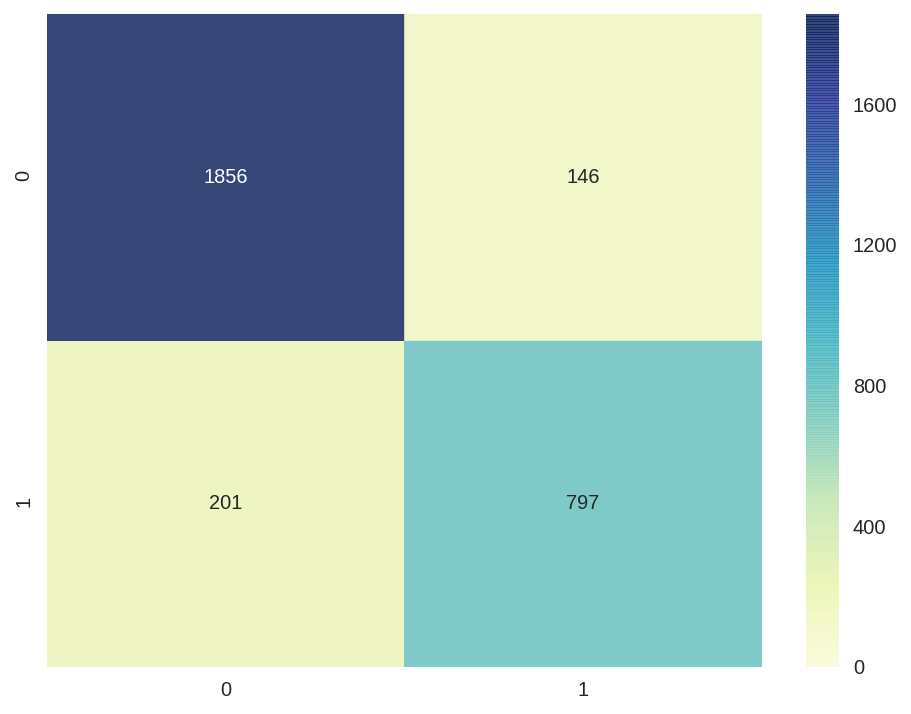

In [34]:
y_pred_3 = model_3.predict_classes(X_test,verbose=0)
y_test_class_3 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_3,y_pred_3))
plot_confusion_matrix(model_3,X_test,y_test_class_3)

In [35]:
train_loss_3, train_accuracy_3 = model_3.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_3 * 100, train_loss_3))
test_loss_3, test_accuracy_3 = model_3.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_3 * 100, test_loss_3))

Training Accuracy = 88.67 %     loss = 0.447549
Testing Accuracy = 88.43 %    loss = 0.452685


### 1.4 Neural Network with L2 Regularization $\lambda=0.001$


In [36]:
regu_4 = regularizers.l2(l=0.001)
model_4 = model(regu_4)
model_4.history = model_4.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 0.6918 - acc: 0.6924 - val_loss: 0.5949 - val_acc: 0.7540
Epoch 2/200
 - 0s - loss: 0.5435 - acc: 0.7872 - val_loss: 0.5024 - val_acc: 0.8100
Epoch 3/200
 - 0s - loss: 0.4903 - acc: 0.8170 - val_loss: 0.4748 - val_acc: 0.8177
Epoch 4/200
 - 0s - loss: 0.4675 - acc: 0.8235 - val_loss: 0.4578 - val_acc: 0.8280
Epoch 5/200
 - 0s - loss: 0.4512 - acc: 0.8299 - val_loss: 0.4469 - val_acc: 0.8307
Epoch 6/200
 - 0s - loss: 0.4380 - acc: 0.8362 - val_loss: 0.4366 - val_acc: 0.8380
Epoch 7/200
 - 0s - loss: 0.4260 - acc: 0.8423 - val_loss: 0.4239 - val_acc: 0.8420
Epoch 8/200
 - 0s - loss: 0.4166 - acc: 0.8463 - val_loss: 0.4171 - val_acc: 0.8480
Epoch 9/200
 - 0s - loss: 0.4091 - acc: 0.8493 - val_loss: 0.4125 - val_acc: 0.8540
Epoch 10/200
 - 0s - loss: 0.4025 - acc: 0.8514 - val_loss: 0.4099 - val_acc: 0.8480
Epoch 11/200
 - 0s - loss: 0.3928 - acc: 0.8561 - val_loss: 0.4043 - val_acc: 0.8507
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.2739 - acc: 0.9109 - val_loss: 0.3042 - val_acc: 0.8960
Epoch 35/200
 - 0s - loss: 0.2728 - acc: 0.9127 - val_loss: 0.3004 - val_acc: 0.8970
Epoch 36/200
 - 0s - loss: 0.2684 - acc: 0.9134 - val_loss: 0.3005 - val_acc: 0.8950
Epoch 37/200
 - 0s - loss: 0.2685 - acc: 0.9113 - val_loss: 0.2985 - val_acc: 0.8993
Epoch 38/200
 - 0s - loss: 0.2647 - acc: 0.9139 - val_loss: 0.3005 - val_acc: 0.8900
Epoch 39/200
 - 0s - loss: 0.2641 - acc: 0.9138 - val_loss: 0.2970 - val_acc: 0.8980
Epoch 40/200
 - 0s - loss: 0.2622 - acc: 0.9162 - val_loss: 0.2985 - val_acc: 0.8993
Epoch 41/200
 - 0s - loss: 0.2605 - acc: 0.9163 - val_loss: 0.2970 - val_acc: 0.8983
Epoch 42/200
 - 0s - loss: 0.2633 - acc: 0.9143 - val_loss: 0.3016 - val_acc: 0.9003
Epoch 43/200
 - 0s - loss: 0.2603 - acc: 0.9162 - val_loss: 0.2940 - val_acc: 0.9013
Epoch 44/200
 - 0s - loss: 0.2586 - acc: 0.9176 - val_loss: 0.2905 - val_acc: 0.9000
Epoch 45/200
 - 0s - loss: 0.2684 - acc: 0.9120 - val_loss: 0.3294 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.2432 - acc: 0.9234 - val_loss: 0.2844 - val_acc: 0.9003
Epoch 69/200
 - 0s - loss: 0.2422 - acc: 0.9217 - val_loss: 0.2868 - val_acc: 0.8983
Epoch 70/200
 - 0s - loss: 0.2426 - acc: 0.9217 - val_loss: 0.2831 - val_acc: 0.9013
Epoch 71/200
 - 0s - loss: 0.2455 - acc: 0.9206 - val_loss: 0.2854 - val_acc: 0.8960
Epoch 72/200
 - 0s - loss: 0.2428 - acc: 0.9206 - val_loss: 0.2884 - val_acc: 0.9050
Epoch 73/200
 - 0s - loss: 0.2419 - acc: 0.9238 - val_loss: 0.2787 - val_acc: 0.9060
Epoch 74/200
 - 0s - loss: 0.2430 - acc: 0.9221 - val_loss: 0.2943 - val_acc: 0.8920
Epoch 75/200
 - 0s - loss: 0.2413 - acc: 0.9228 - val_loss: 0.2865 - val_acc: 0.8970
Epoch 76/200
 - 0s - loss: 0.2410 - acc: 0.9236 - val_loss: 0.2815 - val_acc: 0.9040
Epoch 77/200
 - 0s - loss: 0.2405 - acc: 0.9221 - val_loss: 0.2817 - val_acc: 0.9020
Epoch 78/200
 - 0s - loss: 0.2413 - acc: 0.9226 - val_loss: 0.2836 - val_acc: 0.9007
Epoch 79/200
 - 0s - loss: 0.2410 - acc: 0.9231 - val_loss: 0.289

Epoch 102/200
 - 0s - loss: 0.2322 - acc: 0.9277 - val_loss: 0.2818 - val_acc: 0.9050
Epoch 103/200
 - 0s - loss: 0.2335 - acc: 0.9257 - val_loss: 0.2822 - val_acc: 0.9047
Epoch 104/200
 - 0s - loss: 0.2311 - acc: 0.9275 - val_loss: 0.2820 - val_acc: 0.9037
Epoch 105/200
 - 0s - loss: 0.2348 - acc: 0.9248 - val_loss: 0.2981 - val_acc: 0.8973
Epoch 106/200
 - 0s - loss: 0.2357 - acc: 0.9243 - val_loss: 0.2801 - val_acc: 0.9077
Epoch 107/200
 - 0s - loss: 0.2308 - acc: 0.9284 - val_loss: 0.2773 - val_acc: 0.9040
Epoch 108/200
 - 0s - loss: 0.2324 - acc: 0.9268 - val_loss: 0.2783 - val_acc: 0.9093
Epoch 109/200
 - 0s - loss: 0.2312 - acc: 0.9261 - val_loss: 0.2787 - val_acc: 0.9053
Epoch 110/200
 - 0s - loss: 0.2327 - acc: 0.9279 - val_loss: 0.2806 - val_acc: 0.9087
Epoch 111/200
 - 0s - loss: 0.2327 - acc: 0.9280 - val_loss: 0.2803 - val_acc: 0.9073
Epoch 112/200
 - 0s - loss: 0.2378 - acc: 0.9225 - val_loss: 0.2859 - val_acc: 0.8993
Epoch 113/200
 - 0s - loss: 0.2309 - acc: 0.9279 - val

Epoch 136/200
 - 0s - loss: 0.2256 - acc: 0.9298 - val_loss: 0.2783 - val_acc: 0.9080
Epoch 137/200
 - 0s - loss: 0.2264 - acc: 0.9294 - val_loss: 0.2761 - val_acc: 0.9090
Epoch 138/200
 - 0s - loss: 0.2273 - acc: 0.9294 - val_loss: 0.2738 - val_acc: 0.9107
Epoch 139/200
 - 0s - loss: 0.2252 - acc: 0.9293 - val_loss: 0.2793 - val_acc: 0.9060
Epoch 140/200
 - 0s - loss: 0.2258 - acc: 0.9291 - val_loss: 0.2802 - val_acc: 0.9097
Epoch 141/200
 - 0s - loss: 0.2261 - acc: 0.9297 - val_loss: 0.2888 - val_acc: 0.9050
Epoch 142/200
 - 0s - loss: 0.2269 - acc: 0.9291 - val_loss: 0.2739 - val_acc: 0.9100
Epoch 143/200
 - 0s - loss: 0.2262 - acc: 0.9301 - val_loss: 0.2821 - val_acc: 0.9077
Epoch 144/200
 - 0s - loss: 0.2268 - acc: 0.9307 - val_loss: 0.2774 - val_acc: 0.9100
Epoch 145/200
 - 0s - loss: 0.2247 - acc: 0.9297 - val_loss: 0.2841 - val_acc: 0.9043
Epoch 146/200
 - 0s - loss: 0.2263 - acc: 0.9292 - val_loss: 0.2780 - val_acc: 0.9083
Epoch 147/200
 - 0s - loss: 0.2263 - acc: 0.9303 - val

Epoch 170/200
 - 0s - loss: 0.2243 - acc: 0.9315 - val_loss: 0.2818 - val_acc: 0.9083
Epoch 171/200
 - 0s - loss: 0.2225 - acc: 0.9324 - val_loss: 0.2792 - val_acc: 0.9083
Epoch 172/200
 - 0s - loss: 0.2221 - acc: 0.9320 - val_loss: 0.2772 - val_acc: 0.9103
Epoch 173/200
 - 0s - loss: 0.2225 - acc: 0.9306 - val_loss: 0.2732 - val_acc: 0.9120
Epoch 174/200
 - 0s - loss: 0.2208 - acc: 0.9313 - val_loss: 0.2762 - val_acc: 0.9110
Epoch 175/200
 - 0s - loss: 0.2247 - acc: 0.9327 - val_loss: 0.2814 - val_acc: 0.9090
Epoch 176/200
 - 0s - loss: 0.2222 - acc: 0.9320 - val_loss: 0.2808 - val_acc: 0.9087
Epoch 177/200
 - 0s - loss: 0.2201 - acc: 0.9325 - val_loss: 0.2813 - val_acc: 0.9087
Epoch 178/200
 - 0s - loss: 0.2250 - acc: 0.9332 - val_loss: 0.2919 - val_acc: 0.8983
Epoch 179/200
 - 0s - loss: 0.2219 - acc: 0.9312 - val_loss: 0.2793 - val_acc: 0.9093
Epoch 180/200
 - 0s - loss: 0.2215 - acc: 0.9320 - val_loss: 0.2755 - val_acc: 0.9083
Epoch 181/200
 - 0s - loss: 0.2222 - acc: 0.9308 - val

             precision    recall  f1-score   support

          0       0.94      0.92      0.93      2002
          1       0.84      0.89      0.86       998

avg / total       0.91      0.91      0.91      3000



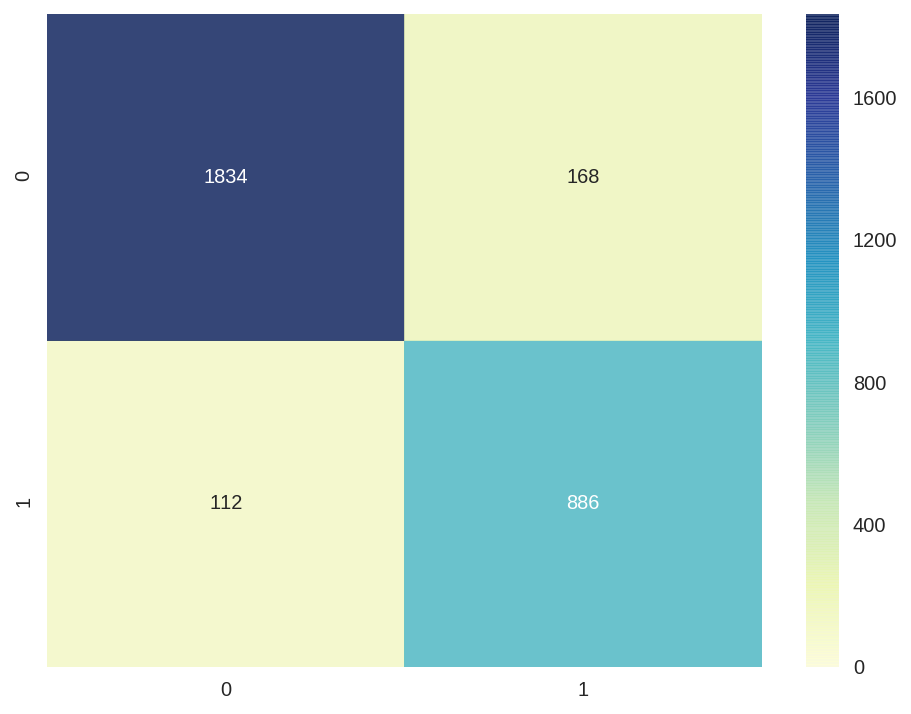

In [37]:
y_pred_4 = model_4.predict_classes(X_test,verbose=0)
y_test_class_4 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_4,y_pred_4))
plot_confusion_matrix(model_4,X_test,y_test_class_4)

In [38]:
train_loss_4, train_accuracy_4 = model_4.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_4 * 100, train_loss_4))
test_loss_4, test_accuracy_4 = model_4.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_4 * 100, test_loss_4))

Training Accuracy = 93.24 %     loss = 0.218285
Testing Accuracy = 90.67 %    loss = 0.282135


### 1.5 Neural Network with L2 Regularization $\lambda=0.0001$

In [39]:
regu_5 = regularizers.l2(l=0.0001)
model_5 = model(regu_5)
model_5.history = model_5.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 0.7007 - acc: 0.6200 - val_loss: 0.6737 - val_acc: 0.7170
Epoch 2/200
 - 0s - loss: 0.5532 - acc: 0.7494 - val_loss: 0.4537 - val_acc: 0.7920
Epoch 3/200
 - 0s - loss: 0.4315 - acc: 0.8065 - val_loss: 0.4016 - val_acc: 0.8233
Epoch 4/200
 - 0s - loss: 0.4003 - acc: 0.8231 - val_loss: 0.3865 - val_acc: 0.8327
Epoch 5/200
 - 0s - loss: 0.3849 - acc: 0.8325 - val_loss: 0.3772 - val_acc: 0.8420
Epoch 6/200
 - 0s - loss: 0.3714 - acc: 0.8391 - val_loss: 0.3703 - val_acc: 0.8417
Epoch 7/200
 - 0s - loss: 0.3638 - acc: 0.8447 - val_loss: 0.3651 - val_acc: 0.8480
Epoch 8/200
 - 0s - loss: 0.3573 - acc: 0.8487 - val_loss: 0.3614 - val_acc: 0.8480
Epoch 9/200
 - 0s - loss: 0.3517 - acc: 0.8522 - val_loss: 0.3590 - val_acc: 0.8483
Epoch 10/200
 - 0s - loss: 0.3474 - acc: 0.8537 - val_loss: 0.3563 - val_acc: 0.8500
Epoch 11/200
 - 0s - loss: 0.3415 - acc: 0.8586 - val_loss: 0.3588 - val_acc: 0.8490
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.2210 - acc: 0.9137 - val_loss: 0.2655 - val_acc: 0.8973
Epoch 35/200
 - 0s - loss: 0.2203 - acc: 0.9141 - val_loss: 0.2626 - val_acc: 0.8963
Epoch 36/200
 - 0s - loss: 0.2228 - acc: 0.9123 - val_loss: 0.2658 - val_acc: 0.8950
Epoch 37/200
 - 0s - loss: 0.2155 - acc: 0.9166 - val_loss: 0.2611 - val_acc: 0.8997
Epoch 38/200
 - 0s - loss: 0.2174 - acc: 0.9156 - val_loss: 0.2532 - val_acc: 0.9010
Epoch 39/200
 - 0s - loss: 0.2157 - acc: 0.9170 - val_loss: 0.2543 - val_acc: 0.9023
Epoch 40/200
 - 0s - loss: 0.2131 - acc: 0.9168 - val_loss: 0.2573 - val_acc: 0.8990
Epoch 41/200
 - 0s - loss: 0.2126 - acc: 0.9174 - val_loss: 0.2570 - val_acc: 0.9003
Epoch 42/200
 - 0s - loss: 0.2123 - acc: 0.9179 - val_loss: 0.2517 - val_acc: 0.9027
Epoch 43/200
 - 0s - loss: 0.2112 - acc: 0.9176 - val_loss: 0.2575 - val_acc: 0.9023
Epoch 44/200
 - 0s - loss: 0.2067 - acc: 0.9203 - val_loss: 0.2545 - val_acc: 0.9063
Epoch 45/200
 - 0s - loss: 0.2054 - acc: 0.9209 - val_loss: 0.2540 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.1902 - acc: 0.9282 - val_loss: 0.2516 - val_acc: 0.9070
Epoch 69/200
 - 0s - loss: 0.1882 - acc: 0.9298 - val_loss: 0.2553 - val_acc: 0.9027
Epoch 70/200
 - 0s - loss: 0.1910 - acc: 0.9287 - val_loss: 0.2696 - val_acc: 0.9027
Epoch 71/200
 - 0s - loss: 0.1905 - acc: 0.9293 - val_loss: 0.2626 - val_acc: 0.9037
Epoch 72/200
 - 0s - loss: 0.1833 - acc: 0.9308 - val_loss: 0.2495 - val_acc: 0.9073
Epoch 73/200
 - 0s - loss: 0.1834 - acc: 0.9313 - val_loss: 0.2550 - val_acc: 0.9033
Epoch 74/200
 - 0s - loss: 0.1814 - acc: 0.9333 - val_loss: 0.2546 - val_acc: 0.9020
Epoch 75/200
 - 0s - loss: 0.1845 - acc: 0.9312 - val_loss: 0.2571 - val_acc: 0.9010
Epoch 76/200
 - 0s - loss: 0.1813 - acc: 0.9327 - val_loss: 0.2534 - val_acc: 0.9043
Epoch 77/200
 - 0s - loss: 0.1815 - acc: 0.9310 - val_loss: 0.2515 - val_acc: 0.9067
Epoch 78/200
 - 0s - loss: 0.1800 - acc: 0.9315 - val_loss: 0.2513 - val_acc: 0.9040
Epoch 79/200
 - 0s - loss: 0.1820 - acc: 0.9308 - val_loss: 0.250

Epoch 102/200
 - 0s - loss: 0.1664 - acc: 0.9388 - val_loss: 0.2539 - val_acc: 0.9080
Epoch 103/200
 - 0s - loss: 0.1660 - acc: 0.9400 - val_loss: 0.2643 - val_acc: 0.9047
Epoch 104/200
 - 0s - loss: 0.1693 - acc: 0.9377 - val_loss: 0.2557 - val_acc: 0.9027
Epoch 105/200
 - 0s - loss: 0.1685 - acc: 0.9373 - val_loss: 0.2650 - val_acc: 0.9037
Epoch 106/200
 - 0s - loss: 0.1673 - acc: 0.9379 - val_loss: 0.2509 - val_acc: 0.9073
Epoch 107/200
 - 0s - loss: 0.1703 - acc: 0.9371 - val_loss: 0.2842 - val_acc: 0.8947
Epoch 108/200
 - 0s - loss: 0.1708 - acc: 0.9357 - val_loss: 0.2612 - val_acc: 0.9007
Epoch 109/200
 - 0s - loss: 0.1651 - acc: 0.9400 - val_loss: 0.2663 - val_acc: 0.9053
Epoch 110/200
 - 0s - loss: 0.1674 - acc: 0.9376 - val_loss: 0.2553 - val_acc: 0.9077
Epoch 111/200
 - 0s - loss: 0.1626 - acc: 0.9393 - val_loss: 0.2550 - val_acc: 0.9093
Epoch 112/200
 - 0s - loss: 0.1651 - acc: 0.9383 - val_loss: 0.2647 - val_acc: 0.9033
Epoch 113/200
 - 0s - loss: 0.1647 - acc: 0.9418 - val

Epoch 136/200
 - 0s - loss: 0.1536 - acc: 0.9445 - val_loss: 0.2630 - val_acc: 0.9097
Epoch 137/200
 - 0s - loss: 0.1518 - acc: 0.9464 - val_loss: 0.2658 - val_acc: 0.9050
Epoch 138/200
 - 0s - loss: 0.1526 - acc: 0.9454 - val_loss: 0.2629 - val_acc: 0.9050
Epoch 139/200
 - 0s - loss: 0.1509 - acc: 0.9452 - val_loss: 0.2659 - val_acc: 0.9070
Epoch 140/200
 - 0s - loss: 0.1513 - acc: 0.9448 - val_loss: 0.2698 - val_acc: 0.9020
Epoch 141/200
 - 0s - loss: 0.1531 - acc: 0.9443 - val_loss: 0.2670 - val_acc: 0.9070
Epoch 142/200
 - 0s - loss: 0.1574 - acc: 0.9410 - val_loss: 0.2710 - val_acc: 0.9077
Epoch 143/200
 - 0s - loss: 0.1533 - acc: 0.9444 - val_loss: 0.2625 - val_acc: 0.9090
Epoch 144/200
 - 0s - loss: 0.1507 - acc: 0.9458 - val_loss: 0.2555 - val_acc: 0.9093
Epoch 145/200
 - 0s - loss: 0.1495 - acc: 0.9466 - val_loss: 0.2625 - val_acc: 0.9077
Epoch 146/200
 - 0s - loss: 0.1502 - acc: 0.9473 - val_loss: 0.2664 - val_acc: 0.9073
Epoch 147/200
 - 0s - loss: 0.1451 - acc: 0.9485 - val

Epoch 170/200
 - 0s - loss: 0.1425 - acc: 0.9498 - val_loss: 0.2742 - val_acc: 0.9057
Epoch 171/200
 - 0s - loss: 0.1380 - acc: 0.9510 - val_loss: 0.2705 - val_acc: 0.9083
Epoch 172/200
 - 0s - loss: 0.1396 - acc: 0.9524 - val_loss: 0.2830 - val_acc: 0.9083
Epoch 173/200
 - 0s - loss: 0.1402 - acc: 0.9502 - val_loss: 0.2734 - val_acc: 0.9103
Epoch 174/200
 - 0s - loss: 0.1398 - acc: 0.9508 - val_loss: 0.2875 - val_acc: 0.9057
Epoch 175/200
 - 0s - loss: 0.1374 - acc: 0.9551 - val_loss: 0.2703 - val_acc: 0.9080
Epoch 176/200
 - 0s - loss: 0.1378 - acc: 0.9510 - val_loss: 0.2737 - val_acc: 0.9093
Epoch 177/200
 - 0s - loss: 0.1403 - acc: 0.9505 - val_loss: 0.2774 - val_acc: 0.9050
Epoch 178/200
 - 0s - loss: 0.1377 - acc: 0.9517 - val_loss: 0.2664 - val_acc: 0.9087
Epoch 179/200
 - 0s - loss: 0.1405 - acc: 0.9526 - val_loss: 0.2774 - val_acc: 0.9090
Epoch 180/200
 - 0s - loss: 0.1383 - acc: 0.9539 - val_loss: 0.2884 - val_acc: 0.9033
Epoch 181/200
 - 0s - loss: 0.1450 - acc: 0.9487 - val

             precision    recall  f1-score   support

          0       0.93      0.90      0.91      2002
          1       0.81      0.86      0.83       998

avg / total       0.89      0.89      0.89      3000



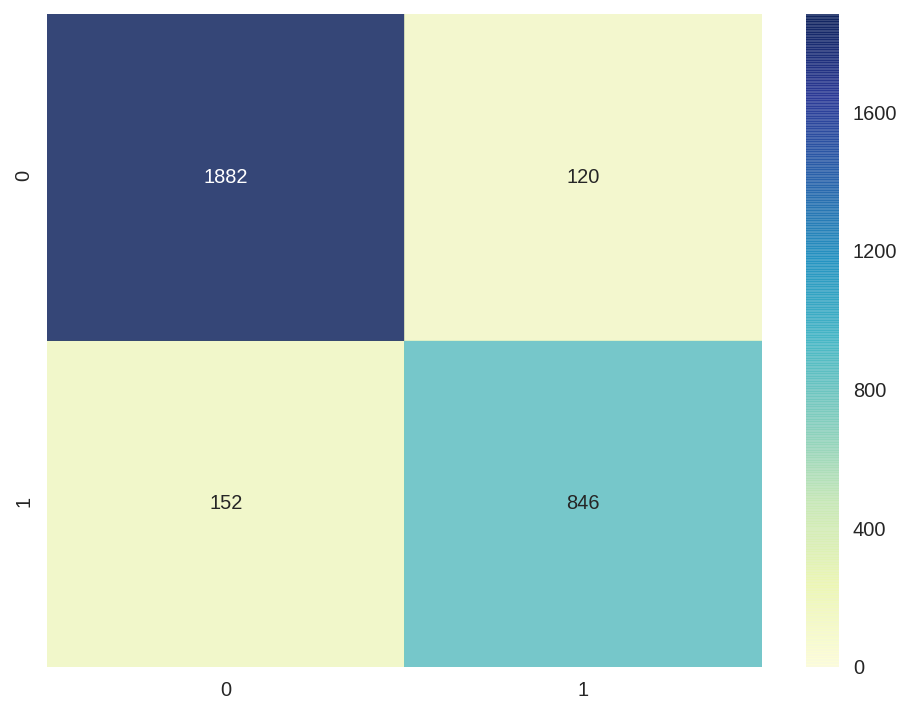

In [40]:
y_pred_5 = model_1.predict_classes(X_test,verbose=0)
y_test_class_5 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_5,y_pred_5))
plot_confusion_matrix(model_5,X_test,y_test_class_5)

In [41]:
train_loss_5, train_accuracy_5 = model_5.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_5 * 100, train_loss_5))
test_loss_5, test_accuracy_5 = model_5.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_5 * 100, test_loss_5))

Training Accuracy = 95.98 %     loss = 0.123945
Testing Accuracy = 90.93 %    loss = 0.273021


## Plot Training and Testing Accuracy and Loss 

In [0]:
colors = sns.color_palette("husl", 8)
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

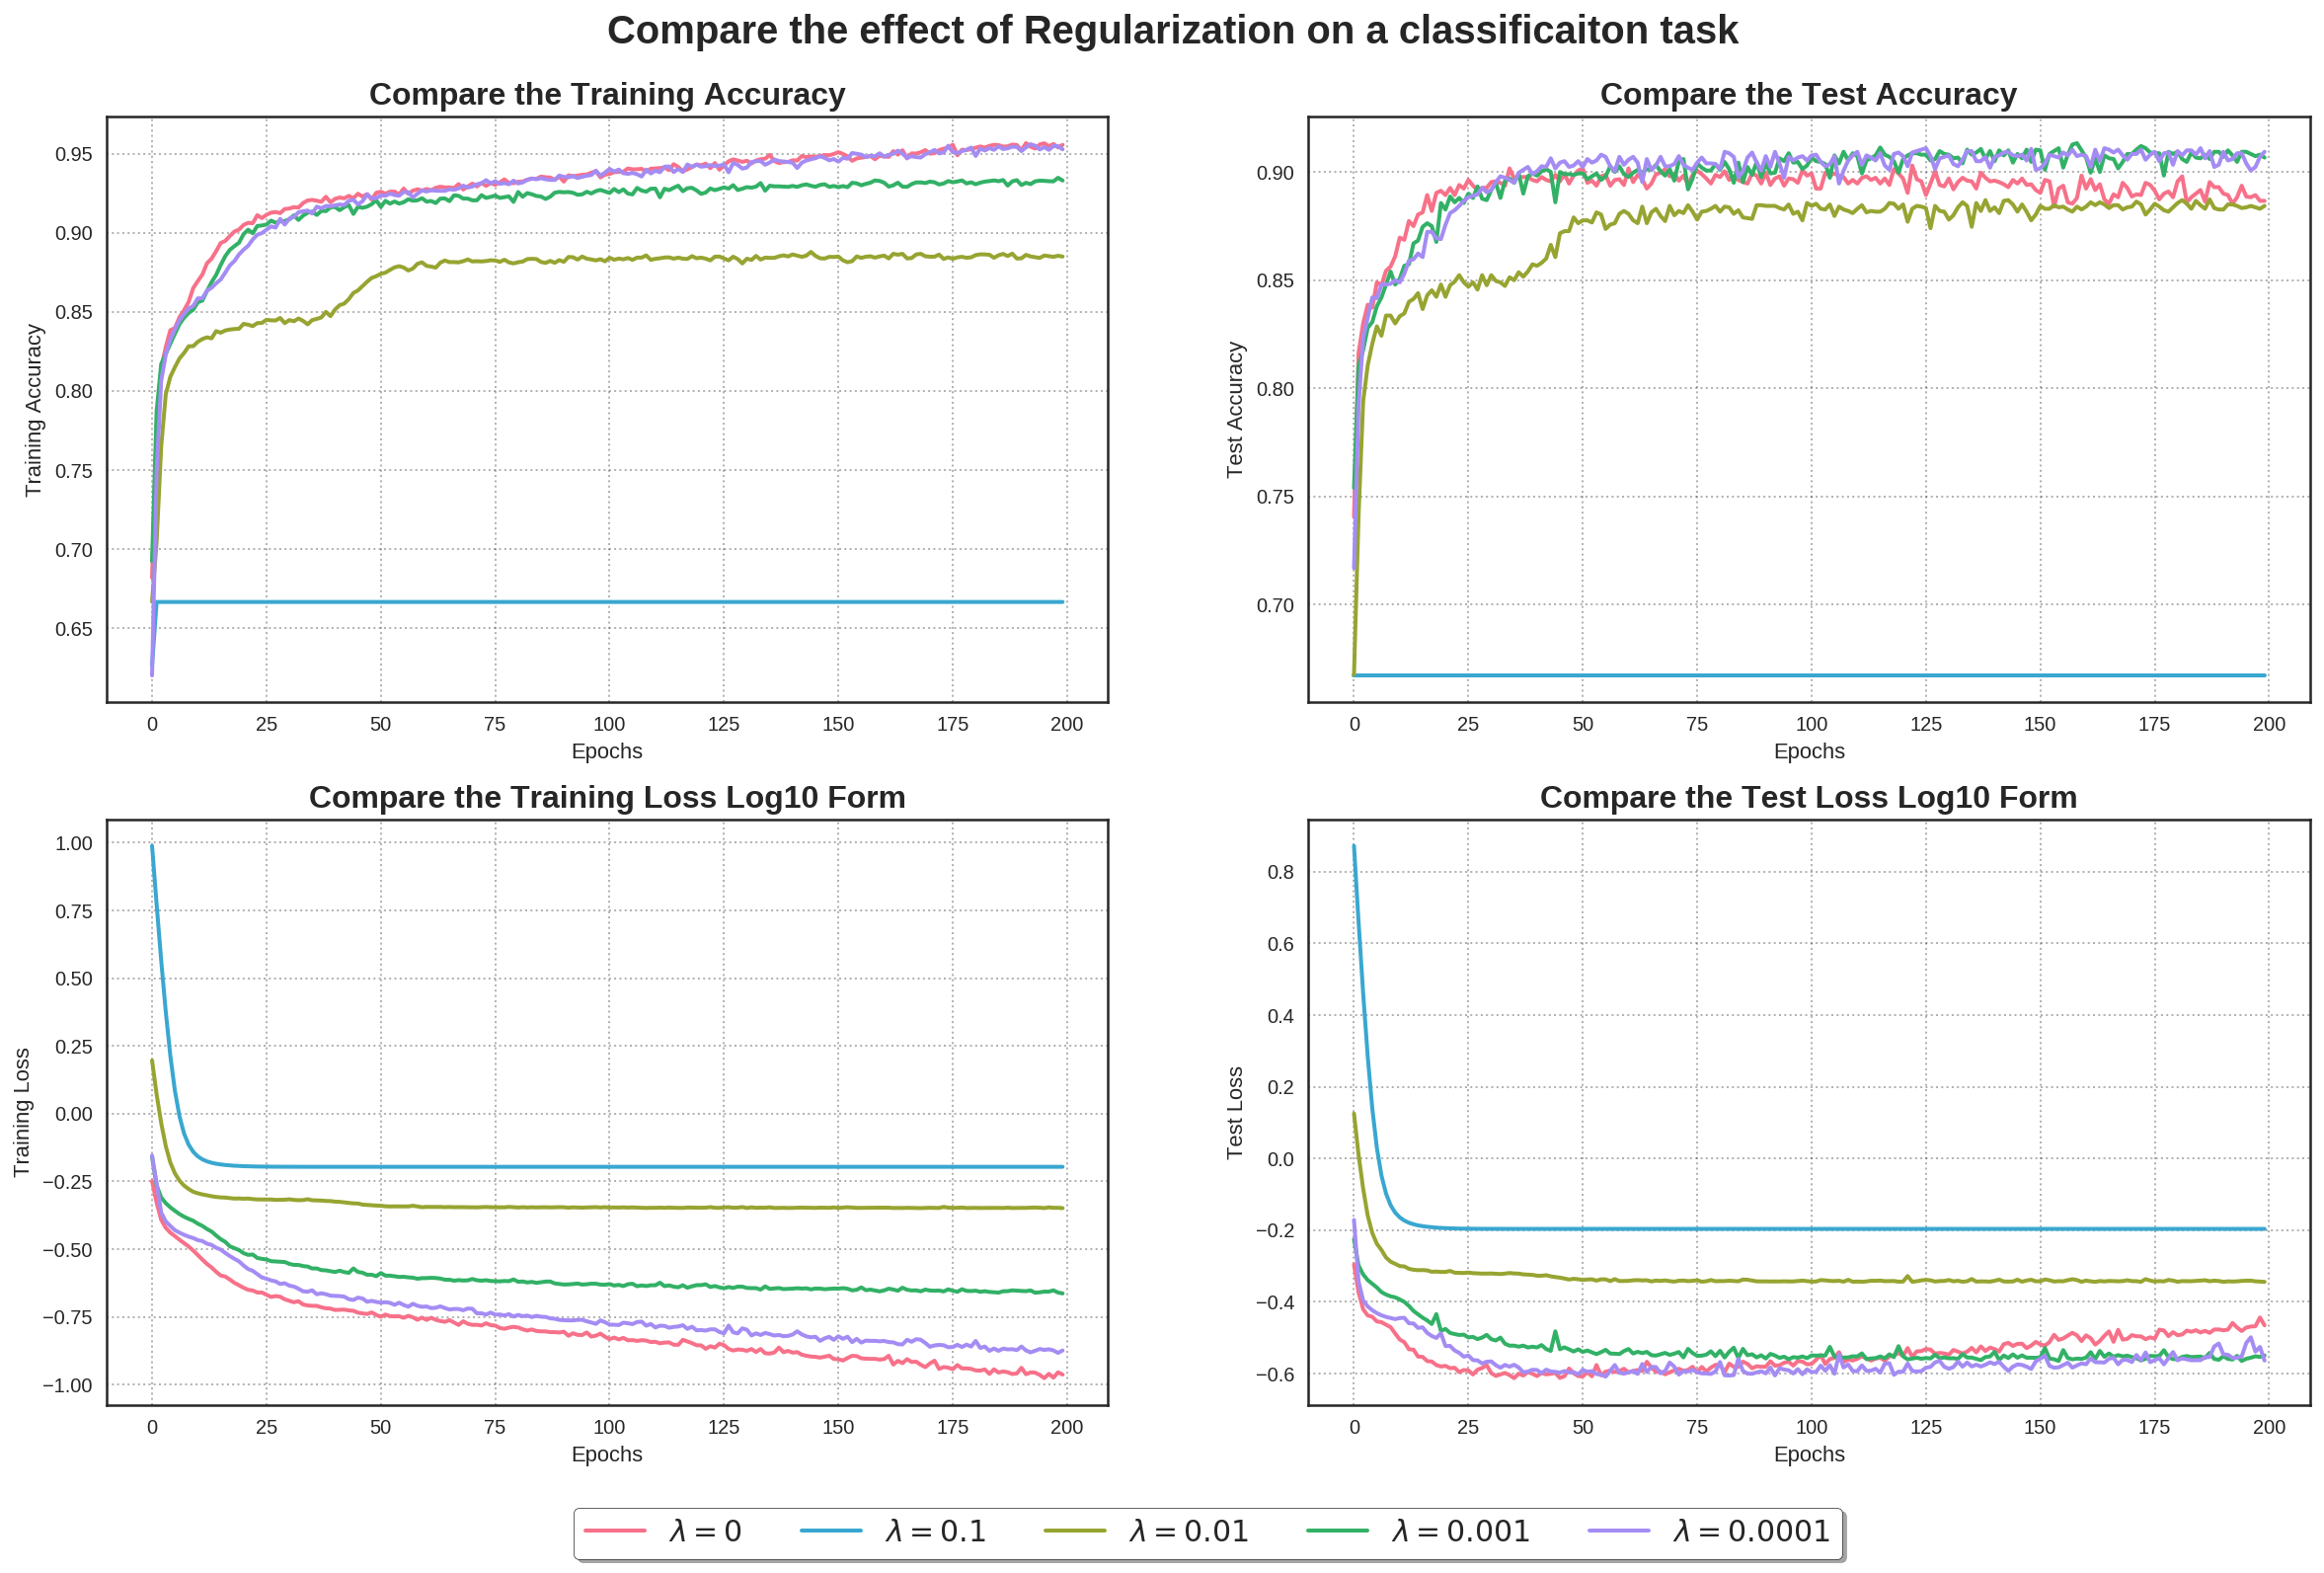

In [46]:
plt.style.use('seaborn-white')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,12))
ax1.plot(model_1.history.history['acc'],color=colors[0],label='$\lambda=0$')
ax1.plot(model_2.history.history['acc'],color=colors[5],label='$\lambda=0.1$')
ax1.plot(model_3.history.history['acc'],color=colors[2],label='$\lambda=0.01$')
ax1.plot(model_4.history.history['acc'],color=colors[3],label='$\lambda=0.001$')
ax1.plot(model_5.history.history['acc'],color=colors[6],label='$\lambda=0.0001$')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')
ax1.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax1.set_title('Compare the Training Accuracy',fontsize=16, fontweight='bold')


ax2.plot(model_1.history.history['val_acc'],color=colors[0],label='$\lambda=0$')
ax2.plot(model_2.history.history['val_acc'],color=colors[5],label='$\lambda=0.1$')
ax2.plot(model_3.history.history['val_acc'],color=colors[2],label='$\lambda=0.01$')
ax2.plot(model_4.history.history['val_acc'],color=colors[3],label='$\lambda=0.001$')
ax2.plot(model_5.history.history['val_acc'],color=colors[6],label='$\lambda=0.0001$')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Test Accuracy')
ax2.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax2.set_title('Compare the Test Accuracy',fontsize=16, fontweight='bold')


ax3.plot(np.log10(model_1.history.history['loss']),color=colors[0],label='$\lambda=0$')
ax3.plot(np.log10(model_2.history.history['loss']),color=colors[5],label='$\lambda=0.1$')
ax3.plot(np.log10(model_3.history.history['loss']),color=colors[2],label='$\lambda=0.01$')
ax3.plot(np.log10(model_4.history.history['loss']),color=colors[3],label='$\lambda=0.001$')
ax3.plot(np.log10(model_5.history.history['loss']),color=colors[6],label='$\lambda=0.0001$')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Training Loss')
ax3.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax3.set_title('Compare the Training Loss Log10 Form',fontsize=16, fontweight='bold')


ax4.plot(np.log10(model_1.history.history['val_loss']),color=colors[0],label='$\lambda=0$')
ax4.plot(np.log10(model_2.history.history['val_loss']),color=colors[5],label='$\lambda=0.1$')
ax4.plot(np.log10(model_3.history.history['val_loss']),color=colors[2],label='$\lambda=0.01$')
ax4.plot(np.log10(model_4.history.history['val_loss']),color=colors[3],label='$\lambda=0.001$')
ax4.plot(np.log10(model_5.history.history['val_loss']),color=colors[6],label='$\lambda=0.0001$')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Test Loss')
ax4.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax4.set_title('Compare the Test Loss Log10 Form',fontsize=16, fontweight='bold')

plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15),
          ncol=5, fancybox=True, shadow=True, frameon=True,edgecolor='black',fontsize=15)

fig.suptitle('Compare the effect of Regularization on a classificaiton task',fontsize=20, fontweight='bold',y=0.94)
plt.show()